<hr style="border:2px solid black"></hr>

# Initialization

In [2]:
%load_ext autotime
%matplotlib inline

from toolbox.initialize import *


# spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 1.93 ms


<hr style="border:2px solid black"></hr>

# Cleaning

## Load dataframe

In [4]:
df_path = Config.Path.project_data_root / 'df_clean'
df = t.load_data_from_files(df_path, spark, method='parquet')

# Drop the column: "user_id_prefix".
df = df.drop('user_id_prefix')

# Set the flag that determines whether the middle results
# will be shown.
display_middle_results = True

Loading data from path: "/data/work/shared/s001284/Music_Project/resources/data/df_clean".
	Execution time: 0.71115 s.
time: 721 ms


## Count the rows

In [5]:
n_rows_total = df.count()

print(f'The total number of rows: {n_rows_total:,.0f}.')

The total number of rows: 2,530,475,843.
time: 3.66 s


## Visualize the amount of undefined cells in each column

Count the undefined cells in each column:

In [15]:
## COUNT THE UNDEFINED CELLS

# Initialize the dict where the numbers will be stored.
n_undefined = dict()
pct_undefined = dict()

# Count the undefined cells in each column.
for column_name in tqdm(df.columns):
    n_undefined[column_name] = df.where(f.col(column_name).isNull()).count()
    pct_undefined[column_name] = n_undefined[column_name] / n_rows_total * 100

    
## DISPLAY AS PANADAS TABLE

# Define the column names.
property_names = ['Number of cells', 'Percent of total'] 

# Create a dict representing the data.
data = {column_name: [f'{n_undefined[column_name]:,.0f}',
                      f'{pct_undefined[column_name]:.2f}']
        for column_name in n_undefined.keys()}

# Create the pandas dataframe for displaying.
dfp_undefined = pd.DataFrame.from_dict(data,
                                       orient='index',
                                       columns=property_names)

# Display the dataframe
display(dfp_undefined)

,Number of cells,Percent of total
user_id,0,0.00
activity_id,0,0.00
activity_start_time,0,0.00
activity_duration,0,0.00
device_id,"7,253,534",0.29
device_name,"7,258,178",0.29
track_artist,"710,429,434",28.07
track_title,"180,364,595",7.13
track_album,"127,804,616",5.05
track_player,"338,135,480",13.36


time: 6min 9s


Create a bargraph represening the percentage of undefined cells in each column:

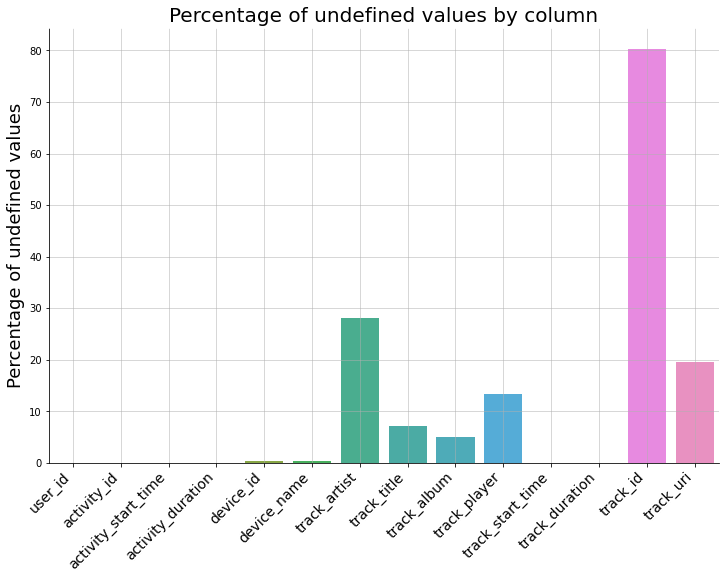

time: 310 ms


In [23]:
# Create a barplot showing the percentage of undefined values in each column.
axes = sns.barplot(x=list(pct_undefined.keys()),
                   y=list(pct_undefined.values()))

# Rotate the tick labels for the x-axes.
labels = axes.set_xticklabels(axes.get_xticklabels(),
                              rotation=45,
                              ha='right',
                              va='top',
                              fontsize=14
                             )

# Annotate the graph.
title = axes.set_title('Percentage of undefined values by column')
# x_label = axes.set_xlabel('Column name')
y_label = axes.set_ylabel('Percentage of undefined values')

# Apply general formatting.
w.format_figure(axes.figure)

## Visualize activities over time

In [10]:
# Compute dataframe showing the number of activities and the total duration
# of these activities per day. Order by activity date.
df_activity_stats = (
    df
    .withColumn('activity_date', f.to_date('activity_start_time'))
    .groupBy('activity_date')
    .agg(f.count('activity_id').alias('n_activities'),
         f.sum('activity_duration').alias('activity_duration_sum'))
    .orderBy(f.asc('activity_date'))
)

# Show the top rows
df_activity_stats.limit(100).toPandas().head(10)

,activity_date,n_activities,activity_duration_sum
0,1970-01-01,1,15
1,1970-02-01,13,20683
2,2000-01-01,17,35343
3,2013-06-11,3,873
4,2013-08-21,1,13
5,2013-09-04,1,1
6,2013-09-14,5,2008
7,2013-09-20,1,8
8,2013-09-26,12,26184
9,2013-09-28,1,18


time: 2min 23s


In [37]:
# # Histogram
# buckets = [int(10*1.2**i) for i in range(0,30)]
# price_histogram = df_listings_rome.select('price').rdd.flatMap(lambda x: x).histogram(buckets)

def get_column(df, column_name):
    return df_activity_stats.select(column_name).rdd.flatMap(lambda x: x).collect()

date = get_column(df_activity_stats, 'activity_date')
n_activities = get_column(df_activity_stats, 'n_activities')
duration_sum = get_column(df_activity_stats, 'activity_duration_sum')

time: 7min 35s


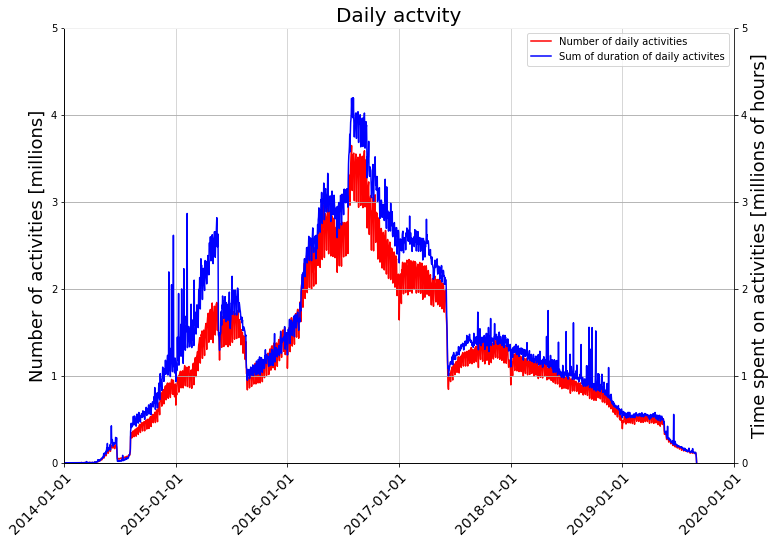

time: 438 ms


In [73]:
# Create a figure and axes for the plot.
figure, axes_left = empty_figure()

# Create a twin axes for two different y-axes on the same plot.
axes_right = axes_left.twinx()

# Plot the data
plot_left = axes_left.plot(date, np.array(n_activities) / 1e6,
                      color='red',
                      label='Number of daily activities')

plot_right = axes_right.plot(date, np.array(duration_sum) / (3600 * 1e6),
                         color='blue',
                         label='Sum of duration of daily activites')


# Set titles and labels.
title = axes_left.set_title('Daily actvity')
xlabel = axes_left.set_xlabel('')
ylabel_left = axes_left.set_ylabel('Number of activities [millions]')
ylabel_right = axes_right.set_ylabel('Time spent on activities [millions of hours]')

# Set tickmarks.
axes_left.xaxis.set_major_locator(mdates.YearLocator(1, month=1, day=1))
x_lim = axes_left.set_xlim((datetime.datetime(2014, 1, 1), datetime.datetime(2020, 1, 1)))
plot = plt.setp(axes_left.get_xticklabels(),
                rotation=45,
                ha="right",
                va='top',
                rotation_mode="anchor",
                fontsize=14)

# Set limits
y_lim_left = axes_left.set_ylim((0, 5))
y_lim_right = axes_right.set_ylim((0, 5))

# Set layout
axes = figure.axes
for ax in axes:
    ax.spines['top'].set_color('white')
    ax.set_facecolor("white")
    ax.xaxis.label.set_fontsize(18)
    ax.yaxis.label.set_fontsize(18)
    ax.title.set_fontsize(20)


# Add a legend
all_plots = plot_left + plot_right
all_labels = [plot.get_label() for plot in all_plots]
legend = axes_left.legend(all_plots, all_labels, loc=0)

# Set grid
axes_left.xaxis.grid(which="both", linewidth=0.5)
axes_left.yaxis.grid(which="both", linewidth=0.5)
axes_right.grid(None)






<hr style="border:2px solid black"></hr>

# Save the dataframe

In [ ]:
# Save the start time for timing.
start_time = time.time()

# Save the dataframe with partitions defined by the first
# two letters of the user ID.
(df
 .withColumn('user_id_prefix', f.col('user_id').substr(0,2))
 .write.mode('overwrite')
 .partitionBy('user_id_prefix')
 .parquet(str(Config.Path.project_data_root / 'df_clean_new'))
)

# Print the execution time.
print(f'Execution time: {time.time() - start_time:.5f} s.')